# Progetto Tesi Calciatori Under 21

## Importazione librerie

In [1]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import time
from request_get import *
from datetime import datetime
from dateutil import relativedelta
import statsmodels.api as sm
from scipy.stats import f_oneway,kstest,spearmanr,pearsonr,kendalltau
from scipy import stats
import numpy as np
import ruptures as rpt
import Rbeast as rb
import pymannkendall as mk
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)


In [2]:
get_table_result()

In [ ]:
url = f"https://www.transfermarkt.it/serie-a/tabelle/wettbewerb/IT1?saison_id=2020"
headers = {'User-Agent': 
                'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
r= requests.get(url, headers=headers)
r.status_code  

soups = soup(r.text, 'html.parser')  # r.content 대신 r.text도 가능
player_info_odd_even= soups.find(id="yw1").find("tbody").find_all("tr")

squadra=[]
posizione=[]
for info in player_info_odd_even:
    player = info.find_all("td")
    #print(player[2])
    squadra.append(player[1].img['alt'])
    posizione.append(int(player[0].text))
  
giocatori = pd.DataFrame(
            {
            "Posizione":posizione,
            "Squadra":squadra,
            }
        )

giocatori.head(20)
#giocatori.to_excel(fr"C:\Users\franc\Documents\Progetto_Calciatori_Under21\classifica.xlsx",index=False)


## Importazione dataset

In [2]:
# le funzioni che seguono servono a prendere i dati da fbref e transfermarkt e salvarli in un file xlsx (definite nel file request_get.py)
#get_fbref()
#get_transfermarkt(2022,1)

In [2]:
uefa_ranking=get_uefa_ranking()
uefa_ranking.head()

,Uefa_Ranking
1969,7.836865
1970,5.514087
1971,8.993416
1972,7.912378
1973,3.796904


## Estrazione minuti di gioco

In [2]:
#get data from tabel
# Calcola i minuti giocati dai giocatori under 21 per ogni anno, stabilendo come under 21 i giocatori nati dopo il 1 Agosto 
mesi = {
    "gen": 1, "feb": 2, "mar": 3, "apr": 4, "mag": 5, "giu": 6, "lug": 7, "ago": 8, "set": 9, "ott": 10, "nov": 11, "dic": 12
}
mins_played=pd.DataFrame(columns=["Minuti giocati under21","Minuti giocati Italiani","Minuti giocati Stranieri","Minuti giocati Oriundi"])
current_year = 2022

# Define the number of years you want to subtract
year_to_subtract = 56

for i in range(year_to_subtract):
    # Calculate the year to use in the URL
    year_url = f"{current_year - i}-{current_year + 1 - i}"
    
    
    #players_fbref=pd.read_excel(f"fbref\SerieA{year_url}-Under21.xlsx")
    players_tm=pd.read_excel(f"transfermarkt\SerieA{year_url}-Under21.xlsx")
    for j in range(len(players_tm)):
        parti = players_tm.loc[j,"Nato"].split('/')
        giorno_nasc = int(parti[0])
        mese_nasc = mesi[parti[1].lower()]  # Mappa il mese in minuscolo
        anno_nasc = int(parti[2])
        data_nasc = datetime(anno_nasc, mese_nasc, giorno_nasc)
        players_tm.loc[j,"Data di nascita"]=data_nasc
        data_inizio=datetime(current_year-i, 8, 1)
        anni=relativedelta.relativedelta(data_inizio, data_nasc).years
        players_tm.loc[j,"Anni"]=anni
    under=players_tm[players_tm["Anni"]<21]
    under_italia=under[under["Nazione"]=="Italia"]
    #under_stranieri = under[~under["Nazione"].str.contains(r'\bItalia\b', case=False, na=False)]
    under_stranieri= under[~under["Nazione"].str.contains(r'\b^Italia$\b|^Italia/\b', case=False, na=False)]
    under_oriundi = under[under["Nazione"].str.contains(r'^Italia/\b', case=False, na=False)]
    #under_stranieri=under[under["Nazione"]!="Italia"]
    mins_played.loc[year_url,"Minuti giocati Italiani"]=under_italia["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati under21"]=under["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Stranieri"]=under_stranieri["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Oriundi"]=under_oriundi["Minuti giocati"].sum()
    

    #mins_played.loc[year_url,"Minuti giocati FB"]=players_fbref["Minuti giocati"].sum()
    #mins_played.loc[year_url,"Minuti giocati TM"]=players_tm["Minuti giocati"].sum()
    #mins_played.loc[year_url,"TM - FB"]=mins_played.loc[year_url,"Minuti giocati FIX"]-mins_played.loc[year_url,"Minuti giocati FB"]




In [77]:
#mins_played=mins_played.iloc[::-1]


### Normalizzazione minuti di gioco

In [3]:
#normalize Minuti giocati to total minutes played in the league and create another column(from 2022-2023 to 2004-2005 divided for 3420 minutes, from 2003-2004 to 1988-1989 divided for 3060 minutes and from 1987-1988 to 1968-1969 divided for 2700 minutes)
#mins_played["Minuti giocati normalizzati Fbref"]=0
#inverte l'ordine delle righe del dataframe con in testa 1968 e coda 2022
mins_played=mins_played.iloc[::-1]

#1967, cioè -56
mins_played[0:21]=mins_played[0:21]/(90*11*30*20)*100
mins_played[21:37]=mins_played[21:37]/(90*11*34*20)*100
mins_played[37:]=mins_played[37:]/(90*11*38*20)*100


"""
#1951, cioè -72
mins_played[0:16]=mins_played[0:16]/(90*11*34*20)*100
mins_played[16:37]=mins_played[16:37]/(90*11*30*20)*100
mins_played[37:53]=mins_played[37:53]/(90*11*34*20)*100
mins_played[53:]=mins_played[53:]/(90*11*38*20)*100 """

"""
mins_played["Minuti giocati totali"]=0
mins_played["Minuti giocati totali"][0:19]=594000
mins_played["Minuti giocati totali"][19:35]=673200
mins_played["Minuti giocati totali"][35:]=752400"""

mins_played["Minuti giocati under21"]=mins_played["Minuti giocati under21"].astype(float)
mins_played["Minuti giocati Italiani"]=mins_played["Minuti giocati Italiani"].astype(float)
mins_played["Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"].astype(float)
mins_played["Minuti giocati Oriundi"]=mins_played["Minuti giocati Oriundi"].astype(float)


In [82]:
#!!!!!!join the dataframe mins_played with uefa_ranking and italy_ranking!!!!!!!!
#mins_played.index=mins_played.index.str[:4].astype(int)
#convert the index of mins_played to DateTime
#mins_played=mins_played.join(uefa_ranking,how='outer')
#mins_played=mins_played.join(italy_ranking,how='outer')

## Grafici

In [21]:
#esegue la media dei minuti giocati normalizzati ogni 8 stagioni
mins_played_10=pd.DataFrame(columns=["Minuti giocati under21"])
mins_played_10.loc["1969-1976","Minuti giocati under21"]=mins_played["Minuti giocati under21"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati under21"]=mins_played["Minuti giocati under21"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati under21"]=mins_played["Minuti giocati under21"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati under21"]=mins_played["Minuti giocati under21"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati under21"]=mins_played["Minuti giocati under21"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati under21"]=mins_played["Minuti giocati under21"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati under21"]=mins_played["Minuti giocati under21"][48:].mean()

mins_played_10.loc["1969-1976","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][0:8]+mins_played["Minuti giocati Oriundi"][0:8]).mean()
mins_played_10.loc["1977-1984","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][8:16]+mins_played["Minuti giocati Oriundi"][8:16]).mean()
mins_played_10.loc["1985-1992","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][16:24]+mins_played["Minuti giocati Oriundi"][16:24]).mean()
mins_played_10.loc["1993-2000","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][24:32]+mins_played["Minuti giocati Oriundi"][24:32]).mean()
mins_played_10.loc["2001-2008","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][32:40]+mins_played["Minuti giocati Oriundi"][32:40]).mean()
mins_played_10.loc["2009-2017","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][40:48]+mins_played["Minuti giocati Oriundi"][40:48]).mean()
mins_played_10.loc["2017-2022","Minuti giocati Italiani"]=(mins_played["Minuti giocati Italiani"][48:]+mins_played["Minuti giocati Oriundi"][48:]).mean()


mins_played_10.loc["1969-1976","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"][48:].mean()

#mins_played_10.head(8)

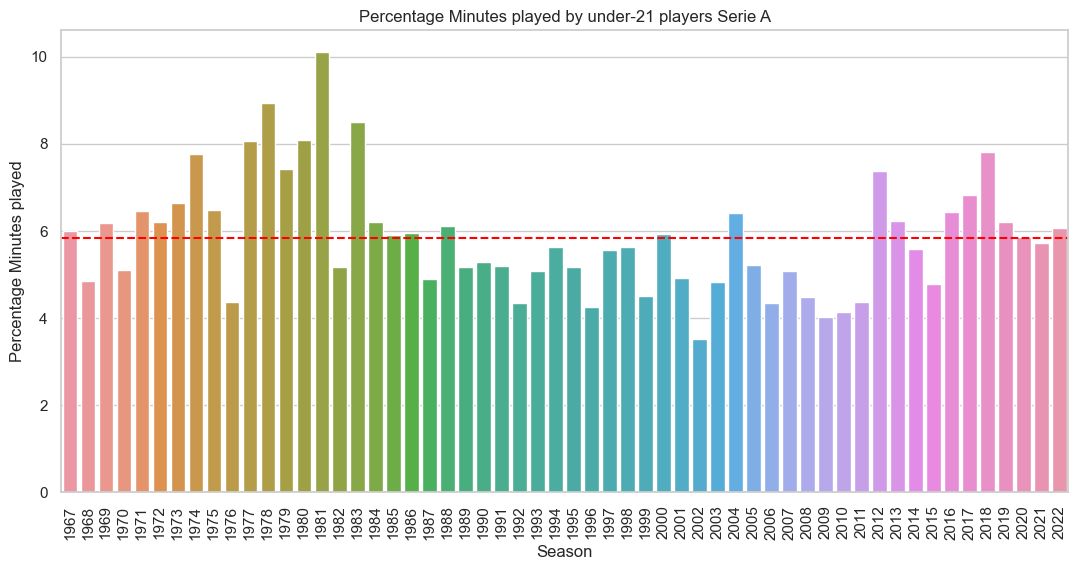

In [43]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(13,6))
sns.barplot(x=mins_played.index, y=mins_played["Minuti giocati under21"])
plt.xticks(rotation=90)
plt.xlabel("Season")
plt.ylabel("Percentage Minutes played")
plt.title("Percentage Minutes played by under-21 players Serie A")
#print line mean
plt.axhline(mins_played["Minuti giocati under21"].mean(), color='red', linestyle='--')


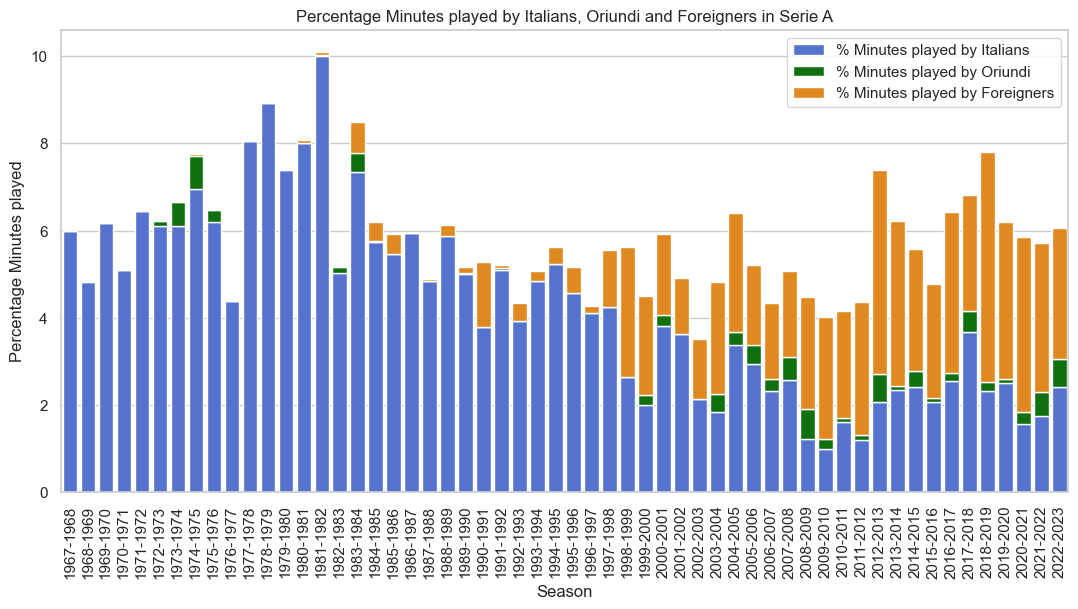

In [57]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(13, 6))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Italiani", color="royalblue",label="% Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Oriundi",color="green",label="% Minutes played by Oriundi", bottom=mins_played["Minuti giocati Italiani"])
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Stranieri",color="darkorange",label="% Minutes played by Foreigners", bottom=mins_played["Minuti giocati Italiani"] + mins_played["Minuti giocati Oriundi"])



# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians, Oriundi and Foreigners in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

Text(0.5, 1.0, 'Percentual minutes played by Under 21 players every 8 seasons')

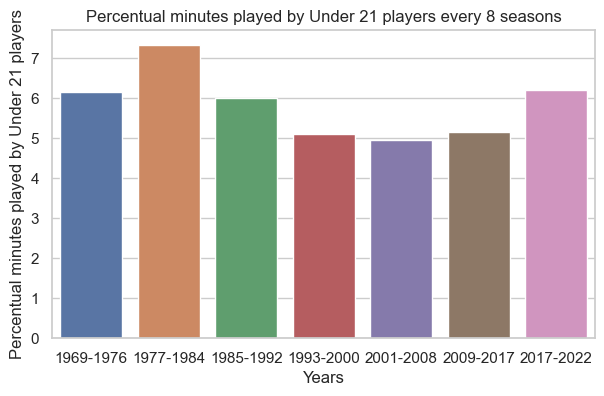

In [10]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7,4))
#plto two column of barplot for the percentage of minutes played by under 21 italians players and for the percentage of minutes played by under 21 foreigner players

sns.barplot(x=mins_played_10.index, y=mins_played_10["Minuti giocati under21"])


plt.xlabel("Years")
plt.ylabel("Percentual minutes played by Under 21 players")
plt.title("Percentual minutes played by Under 21 players every 8 seasons")

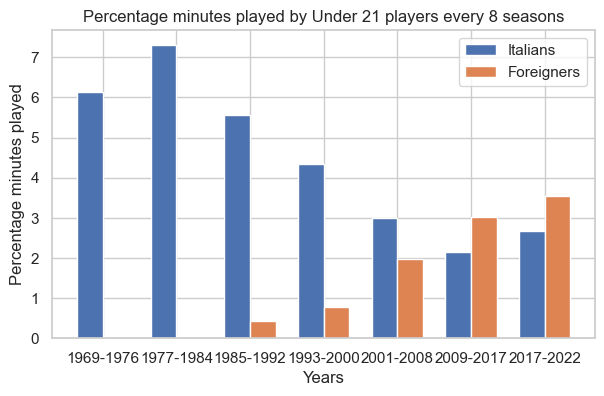

In [11]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7,4))
larghezza_barre = 0.35
barre_italiani = np.arange(len(mins_played_10.index))
barre_stranieri = [x + larghezza_barre for x in barre_italiani]

# Creazione dell'istogramma
plt.bar(barre_italiani, mins_played_10["Minuti giocati Italiani"], width=larghezza_barre, label='Italians')
plt.bar(barre_stranieri, mins_played_10["Minuti giocati Stranieri"],width=larghezza_barre,  label='Foreigners')

# Personalizzazione del grafico
plt.xlabel('Years')
plt.ylabel('Percentage minutes played')
plt.title('Percentage minutes played by Under 21 players every 8 seasons')
plt.xticks([r + larghezza_barre / 2 for r in range(len(mins_played_10.index))], mins_played_10.index)
plt.legend()

# Visualizzazione del grafico
plt.show()

### Nan

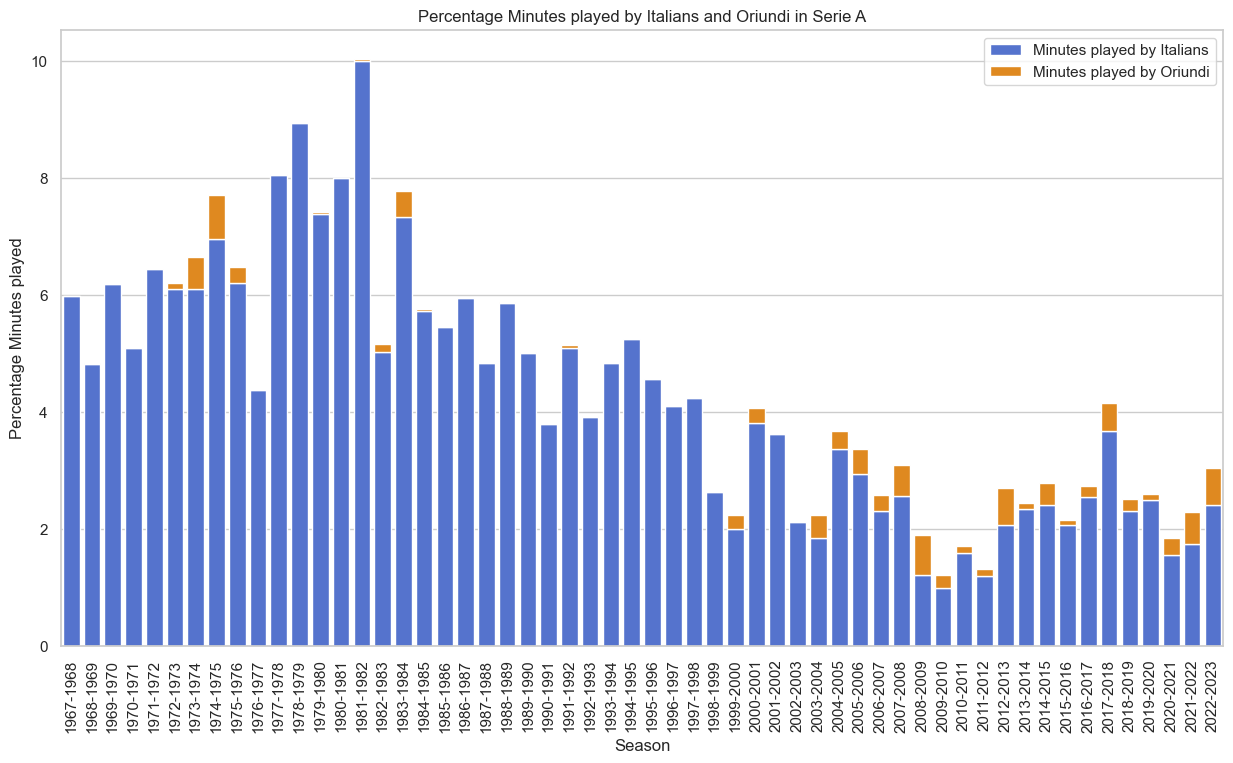

In [14]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Italiani", color="royalblue",label="Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Oriundi",color="darkorange",label="Minutes played by Oriundi", bottom=mins_played["Minuti giocati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians and Oriundi in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

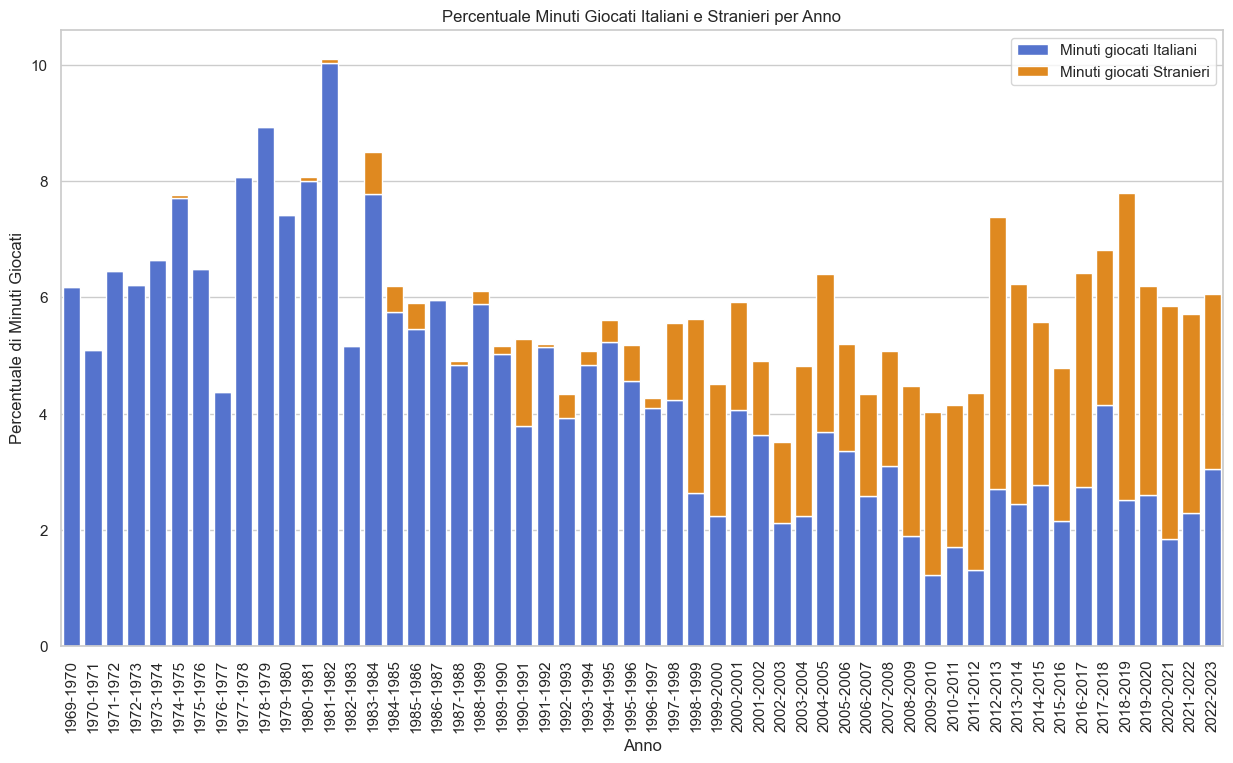

In [ ]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Italiani", color="royalblue",label="Minuti giocati Italiani")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Stranieri",color="darkorange",label="Minuti giocati Stranieri", bottom=mins_played["Minuti giocati normalizzati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Anno')
plt.ylabel('Percentuale di Minuti Giocati')
plt.title('Percentuale Minuti Giocati Italiani e Stranieri per Anno')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

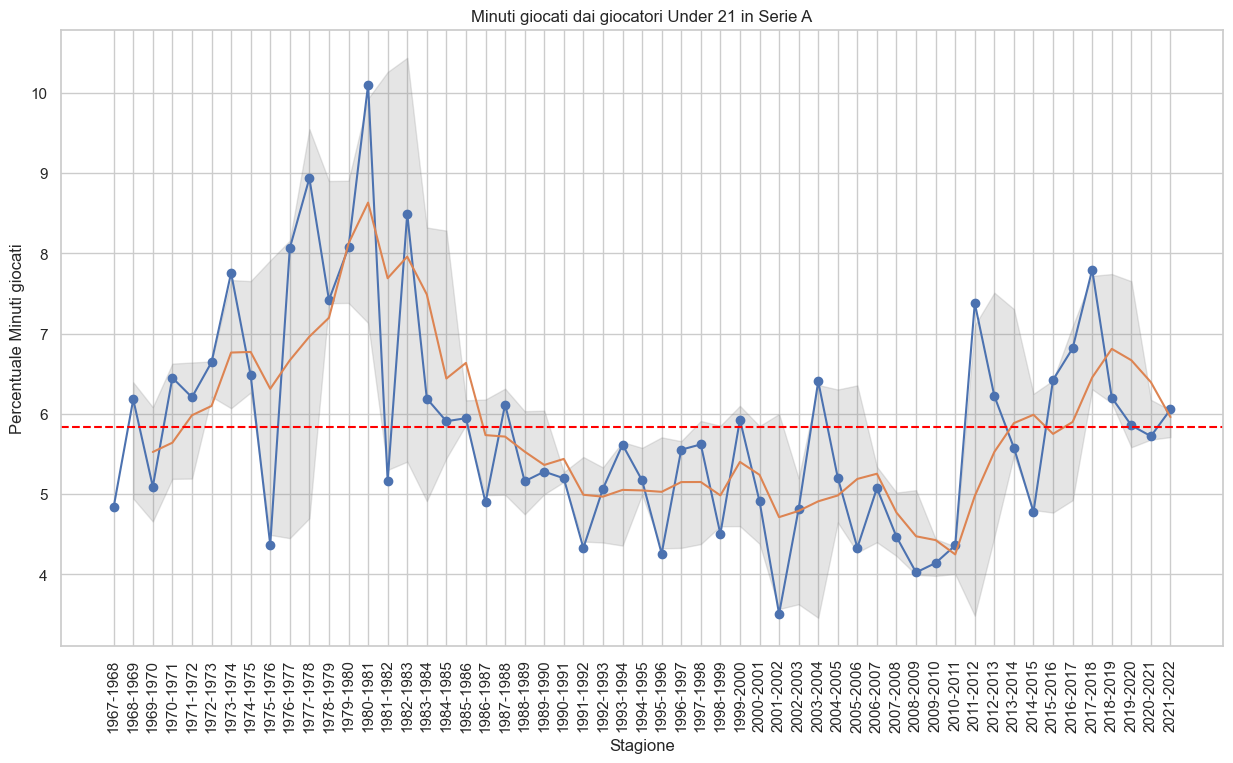

In [33]:
#print a line plot with the minutes played normalized with line mean and marker 
plt.figure(figsize=(15,8))
plt.plot(mins_played[1:].index,mins_played["Minuti giocati under21"][1:],marker='o')

plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A")
#rotate the x ticks

mins_played["Minuti giocati under21"].rolling(4,center=True).mean().plot()
#stampa anche la rolling variance

plt.fill_between(mins_played.index, mins_played["Minuti giocati under21"].rolling(3).mean() - mins_played["Minuti giocati under21"].rolling(3).std(), mins_played["Minuti giocati under21"].rolling(3).mean() + mins_played["Minuti giocati under21"].rolling(3).std(), color='gray', alpha=0.2, label='Dev. Std. Mobile (finestra=5)')


plt.xticks(rotation=90)
plt.axhline(mins_played["Minuti giocati under21"].mean(), color='red', linestyle='--')
plt.show()


## Bayesian changepoint detection con Rbeast

### Analisi changepoint under-21


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.000|*                                               |
|Pr(ncp = 1 )=0.000|*                                               |
|Pr(ncp = 2 )=0.171|*******************                             |
|Pr(ncp = 3 )=0.425|*********************************************** |
|Pr(ncp = 4 )=0.258|*****

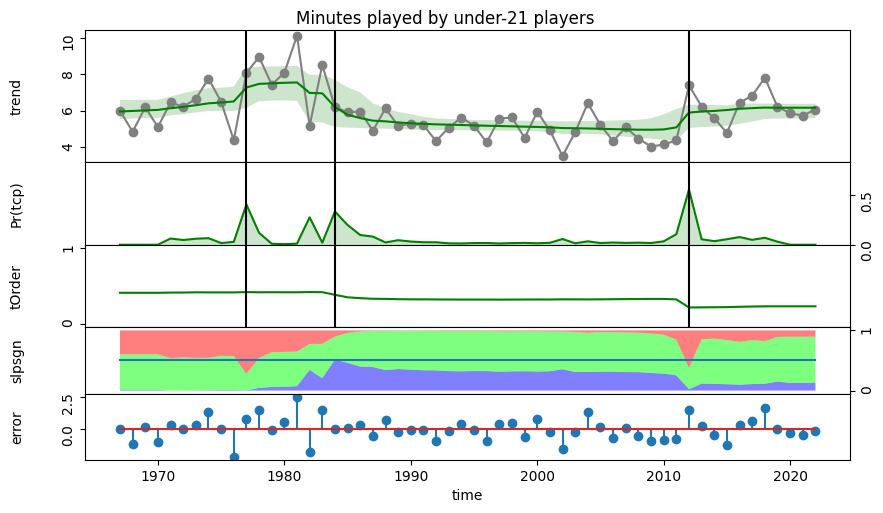

In [39]:
import numpy as np
plt.rcParams['figure.figsize'] = [9, 5]
o=rb.beast(mins_played['Minuti giocati under21'], start=1967, season='none',tcp_minmax=[2,6], print_options = False,print_progress=False)
rb.plot(o,title='Minutes played by under-21 players')
rb.print(o)

In [38]:
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'][0:32], start=1967, deltat=1,period="1.0 year",mcmc_seed=1,print_options = False,print_progress=False)
#rb.plot(o,title='Minutes played by under-21 players from 1967 to 2000')
#rb.print(o)

In [115]:
#Mann_Kendall_Test_Hamed_Rao_Approach 71/84
data = (mins_played["Minuti giocati under21"][3:17])

#fig, ax = plt.subplots(figsize=(8, 5))
res = mk.hamed_rao_modification_test(data)
print("Mann_Kendall_Test_Hamed_Rao_Approach 71-84:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)

#print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept
#plt.xticks(rotation=90)
#ax.plot(data)
#ax.plot(data.index, trend_line)
#ax.legend(['data', 'trend line'])


Mann_Kendall_Test_Hamed_Rao_Approach 71-84:
Trend:  increasing
Z-Value:  2.1897956058054358
P-Value:  0.0285390635703624
Slope:  0.2345959595959597


In [39]:
data = (mins_played["Minuti giocati under21"][16:27])

#fig, ax = plt.subplots(figsize=(8, 5))
res = mk.hamed_rao_modification_test(data)
print("Mann_Kendall_Test_Hamed_Rao_Approach 83-93:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)
#print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept
#plt.xticks(rotation=90)
#ax.plot(data)
#ax.plot(data.index, trend_line)
#ax.legend(['data', 'trend line'])
#rottate the x ticks
#print hte result of Mann_Kendall_Test_Hamed_Rao_Approach 84-92 from res


Mann_Kendall_Test_Hamed_Rao_Approach 83-93:
Trend:  decreasing
Z-Value:  -2.4911966213168735
P-Value:  0.012731364269923606
Slope:  -0.18695286195286198


(<Figure size 800x500 with 5 Axes>,
 array([<Axes: xlabel='[]', ylabel='trend'>,
        <Axes: xlabel='[]', ylabel='Pr(tcp)'>,
        <Axes: xlabel='[]', ylabel='tOrder'>,
        <Axes: xlabel='[]', ylabel='slpsgn'>,
        <Axes: xlabel='time', ylabel='error'>], dtype=object))

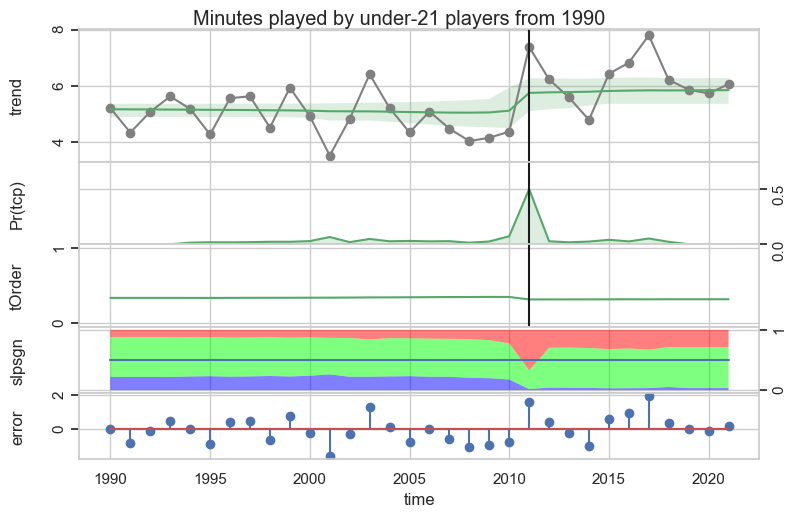

In [43]:
#Trend and changepoint in the number of minutes played by under-21 players from 1990
plt.rcParams['figure.figsize'] = [8, 5]
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'][24:], start=1990,season="none",print_options=False,print_progress=False)
rb.plot(o,title='Minutes played by under-21 players from 1990')
#rb.print(o)

In [71]:
data = (mins_played["Minuti giocati under21"][24:47])



#fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print("Mann_Kendall_Test_Hamed_Rao_Approach 1991-2011:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)

#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data[:-2])
#ax.plot(data[:-2].index, trend_line[:-2])
#ax.legend(['data', 'trend line'])

Mann_Kendall_Test_Hamed_Rao_Approach 1991-2011:
Trend:  no trend
Z-Value:  -0.2590745682575973
P-Value:  0.7955777066463896
Slope:  -0.008117813845368064


In [27]:
#Applying ADCF test
#The ADF test belongs to a category of tests called ‘Unit Root Test’, which is the proper method for testing the stationarity of a time series.
from statsmodels.tsa.stattools import adfuller
# Crea due campioni di dati
# Esegui il test di Dickey-Fuller
result = adfuller(mins_played["Minuti giocati under21"][23:46])
print('Statistiche ADF: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


Statistiche ADF: -4.603778
Valore p: 0.000127
Valori critici:
	1%: -3.788
	5%: -3.013
	10%: -2.646


In [36]:
#Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
from statsmodels.tsa.stattools import kpss

result = kpss(mins_played["Minuti giocati under21"][23:46])
print('\nStatistiche KPSS: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))



Statistiche KPSS: 0.295077
Valore p: 0.100000
Valori critici:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [118]:
data = (mins_played["Minuti giocati under21"][42:])

#fig, ax = plt.subplots(figsize=(8, 4))
res = mk.yue_wang_modification_test(data,alpha=0.05)

print("Mann_Kendall_Test_Hamed_Rao_Approach 2009-2022:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)

#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data)
#ax.plot(data.index, trend_line)
#plt.xticks(rotation=90)
#ax.legend(['data', 'trend line'])

Mann_Kendall_Test_Hamed_Rao_Approach 2009-2022:
Trend:  increasing
Z-Value:  2.768333798096603
P-Value:  0.005634371532819538
Slope:  0.14360108259629795


### Analisi changepoint italiani under-21


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.000|*                                               |
|Pr(ncp = 1 )=0.025|**                                              |
|Pr(ncp = 2 )=0.670|*********************************************** |
|Pr(ncp = 3 )=0.246|******************                              |
|Pr(ncp = 4 )=0.047|**** 

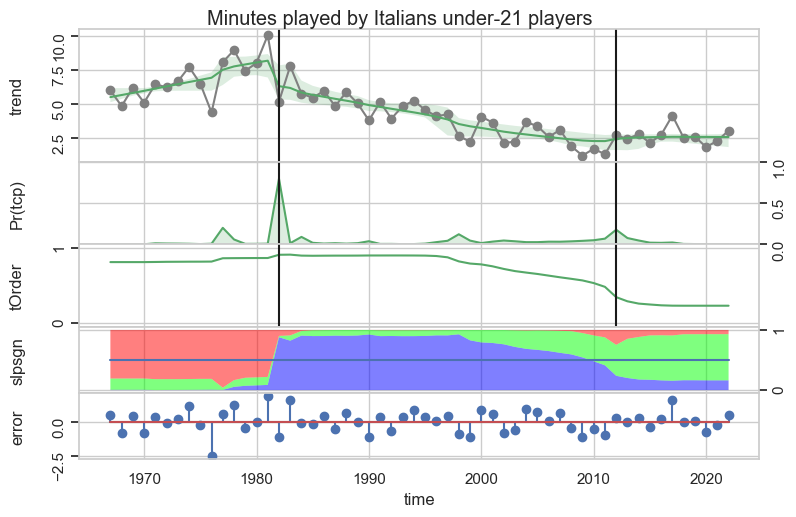

In [44]:
import Rbeast as rb
import numpy as np
o=rb.beast((mins_played['Minuti giocati Italiani'] +mins_played['Minuti giocati Oriundi'] ), start=1967, deltat=1,period="1.0 year",print_options = False,print_progress=False)
rb.plot(o,title='Minutes played by Italians under-21 players')
rb.print(o)


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.000|*                                               |
|Pr(ncp = 1 )=0.000|*                                               |
|Pr(ncp = 2 )=0.000|*                                               |
|Pr(ncp = 3 )=0.760|*********************************************** |
|Pr(ncp = 4 )=0.224|*****

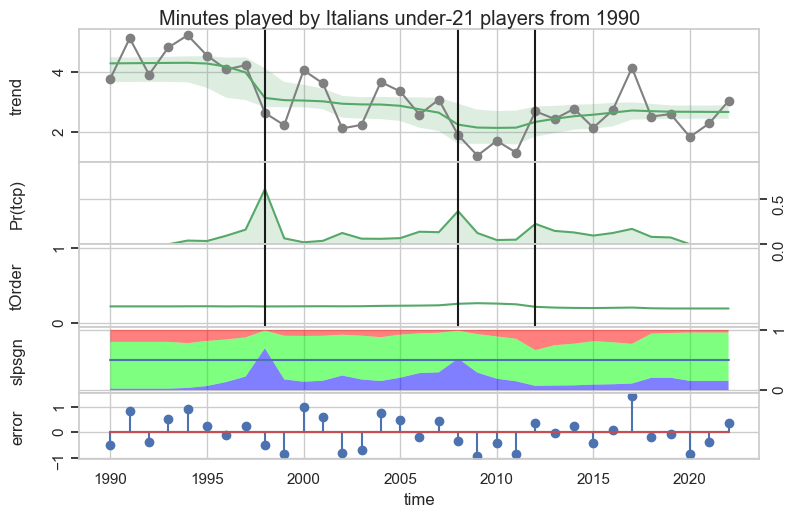

In [45]:
import Rbeast as rb
import numpy as np
o=rb.beast((mins_played['Minuti giocati Italiani'][23:]+mins_played['Minuti giocati Oriundi'][23:]), start=1990, deltat=1,period="1.0 year",tcp_minmax=[3,7],print_options=False,print_progress=False)
rb.plot(o,title='Minutes played by Italians under-21 players from 1990')
rb.print(o)


In [125]:
data = (mins_played["Minuti giocati Italiani"][41:] + mins_played["Minuti giocati Oriundi"][41:])

#fig, ax = plt.subplots(figsize=(6, 4))
res = mk.hamed_rao_modification_test(data,alpha=0.075)
print("Mann_Kendall_Test_Hamed_Rao_Approach 2009-2022 italian player:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p-0.029)
print("Slope: ",res.slope)


#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data[1:])
#ax.plot(data[1:].index, trend_line[1:])
#ax.legend(['data', 'trend line'])

Mann_Kendall_Test_Hamed_Rao_Approach 2009-2022 italian player:
Trend:  increasing
Z-Value:  1.7815379734994166
P-Value:  0.0458246071030847
Slope:  0.08178590415432518


In [135]:
data = (mins_played["Minuti giocati Italiani"][25:41] + mins_played["Minuti giocati Oriundi"][25:41])

#fig, ax = plt.subplots(figsize=(12, 8))
res = mk.original_test(data,alpha=0.05)
print("Mann_Kendall_Test_Hamed_Rao_Approach 1993-2006 italian player:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)
#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data[1:])
#ax.plot(data[1:].index, trend_line[1:])
#ax.legend(['data', 'trend line'])

Mann_Kendall_Test_Hamed_Rao_Approach 1993-2006 italian player:
Trend:  decreasing
Z-Value:  -2.566283462677265
P-Value:  0.010279478485212934
Slope:  -0.13183303624480086


### Autocorrelazione

In [18]:
#test durbin watson per determinare autocorrelazione nei residui del modello di regressione lineare
#Il valore della statistica di Durbin-Watson è sempre compreso tra 0 e 4.
#Un valore di 2 indica che non appare presente alcuna autocorrelazione. Valori piccoli di d indicano che i residui successivi sono, in media, vicini in valore l'uno all'altro, o correlati positivamente.
#Valori grandi di d indicano che i residui successivi sono, in media, molto differenti in valore l'uno dall'altro, o correlati negativamente.

# Fit a linear regression model (you can replace this with your specific model)
model_ita = sm.OLS((mins_played['Minuti giocati Italiani'][42:]+mins_played['Minuti giocati Oriundi'][42:]), np.arange(len(mins_played['Minuti giocati Italiani'][42:]))).fit()
model_2012= sm.OLS(mins_played['Minuti giocati under21'][42:], np.arange(len(mins_played['Minuti giocati under21'][42:]))).fit()
model_1977= sm.OLS(mins_played['Minuti giocati under21'][3:17], np.arange(len(mins_played['Minuti giocati under21'][3:17]))).fit()
model_1984= sm.OLS(mins_played['Minuti giocati under21'][17:26], np.arange(len(mins_played['Minuti giocati under21'][17:26]))).fit()
model_1993= sm.OLS(mins_played['Minuti giocati under21'][25:46], np.arange(len(mins_played['Minuti giocati under21'][25:46]))).fit()
# Calculate Durbin-Watson statistic
durbin_watson_statistic = sm.stats.stattools.durbin_watson(model_ita.resid)
durbin_watson_statistic2012 = sm.stats.stattools.durbin_watson(model_2012.resid)
durbin_watson_statistic1977 = sm.stats.stattools.durbin_watson(model_1977.resid)
durbin_watson_statistic1984 = sm.stats.stattools.durbin_watson(model_1984.resid)
durbin_watson_statistic1993 = sm.stats.stattools.durbin_watson(model_1993.resid)

print(f'Durbin-Watson Statistic 2009/2022 ita: {durbin_watson_statistic}')
print(f'Durbin-Watson Statistic 2009/2022: {durbin_watson_statistic2012}')
print(f'Durbin-Watson Statistic 1971/1983: {durbin_watson_statistic1977}')
print(f'Durbin-Watson Statistic 1984/1993: {durbin_watson_statistic1984}')
print(f'Durbin-Watson Statistic 1993/2011: {durbin_watson_statistic1993}')



Durbin-Watson Statistic 2009/2022 ita: 0.4994279396996094
Durbin-Watson Statistic 2009/2022: 0.2000035691391828
Durbin-Watson Statistic 1971/1983: 0.4330929097344371
Durbin-Watson Statistic 1984/1993: 0.141252494795278
Durbin-Watson Statistic 1993/2011: 0.1737485876087789


In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf((mins_played['Minuti giocati Italiani'][39:]+mins_played['Minuti giocati Oriundi'][39:]), lags=14, ax=ax)
#print only one plot
plt.show()

In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(mins_played["Minuti giocati under21"][39:], lags=14, ax=ax)
plt.show()

In [91]:
mean_74_84=mins_played["Minuti giocati under21"][10:18].mean()
print(f"Media dal 1974 al 1984 : {mean_74_84}")
print(f"Deviazione standard dal 1974 al 1984 : {mins_played['Minuti giocati under21'][10:18].std()}")
#varianza
print(f"Varianza dal 1974 al 1984 : {mins_played['Minuti giocati under21'][11:18].var()}")
#Errore Standard della Media (SEM): è la deviazione standard della distribuzione delle medie campionarie.
print(f"SEM dal 1974 al 1984 : {mins_played['Minuti giocati under21'][10:18].std()/np.sqrt(len(mins_played['Minuti giocati under21'][6:18]))}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_first = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][10:18])-1, loc=mean_74_84, scale=stats.sem(mins_played["Minuti giocati under21"][10:18]))
confidence_interval_first_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][10:18])-1, loc=mean_74_84, scale=stats.sem(mins_played["Minuti giocati under21"][10:18]))
print(f"Intervallo di Confidenza al 95% dal 1974 al 1984: {confidence_interval_first}")
print(f"Intervallo di Confidenza al 90% dal 1974 al 1984: {confidence_interval_first_90}")

mean_85_2011=mins_played["Minuti giocati under21"][20:45].mean()
print(f"Media dal 1985 al 2011 : {mean_85_2011}")
print(f"Varianza dal 1985 al 2011 : {mins_played['Minuti giocati under21'][20:45].var()}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_second = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][20:45])-1, loc=mean_85_2011, scale=stats.sem(mins_played["Minuti giocati under21"][20:45]))
confidence_interval_second_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][20:45])-1, loc=mean_85_2011, scale=stats.sem(mins_played["Minuti giocati under21"][20:45]))
print(f"Intervallo di Confidenza al 95% dal 1985 al 2011: {confidence_interval_second}")
print(f"Intervallo di Confidenza al 90% dal 1985 al 2011: {confidence_interval_second_90}")
mean_2012_2021=mins_played["Minuti giocati under21"][44:].mean()
print(f"Media dal 2012 al 2021 : {mean_2012_2021}")
print(f"Varianza dal 2012 al 2021 : {mins_played['Minuti giocati under21'][44:].var()}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_third = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][44:])-1, loc=mean_2012_2021, scale=stats.sem(mins_played["Minuti giocati under21"][44:]))
confidence_interval_third_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][44:])-1, loc=mean_2012_2021, scale=stats.sem(mins_played["Minuti giocati under21"][44:]))
print(f"Intervallo di Confidenza al 95% dal 2012 al 2021: {confidence_interval_third}")
print(f"Intervallo di Confidenza al 90% dal 2012 al 2021: {confidence_interval_third_90}")




Media dal 1974 al 1984 : 7.807491582491583
Deviazione standard dal 1974 al 1984 : 1.5527096355255912
Varianza dal 1974 al 1984 : 2.7999636887824324
SEM dal 1974 al 1984 : 0.4482286630220129
Intervallo di Confidenza al 95% dal 1974 al 1984: (6.509393842295909, 9.105589322687257)
Intervallo di Confidenza al 90% dal 1974 al 1984: (6.76743280579487, 8.847550359188295)
Media dal 1985 al 2011 : 4.959338816440984
Varianza dal 1985 al 2011 : 0.486575145289361
Intervallo di Confidenza al 95% dal 1985 al 2011: (4.671404581738333, 5.247273051143635)
Intervallo di Confidenza al 90% dal 1985 al 2011: (4.720653867721112, 5.198023765160856)
Media dal 2012 al 2021 : 6.100777511961724
Varianza dal 2012 al 2021 : 0.9461559078964001
Intervallo di Confidenza al 95% dal 2012 al 2021: (5.482749949291241, 6.718805074632206)
Intervallo di Confidenza al 90% dal 2012 al 2021: (5.596500455728177, 6.6050545681952695)


## Correlazione tra minuti stranieri e minuti italiani

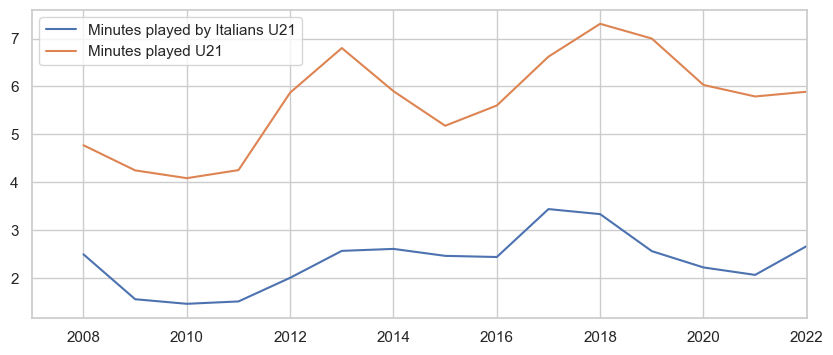

In [44]:
plt.rcParams['figure.figsize'] = [10, 4]
(mins_played["Minuti giocati Italiani"][40:]+mins_played["Minuti giocati Oriundi"][40:]).rolling(2).mean().plot(label='Minutes played by Italians U21')

(mins_played["Minuti giocati under21"][40:]).rolling(2).mean().plot(label='Minutes played U21')
#(mins_played["Minuti giocati under21"][40:]).rolling(2).mean().plot()
#plt.xticks(rotation=90)
#adjust the size of the graph


plt.legend()


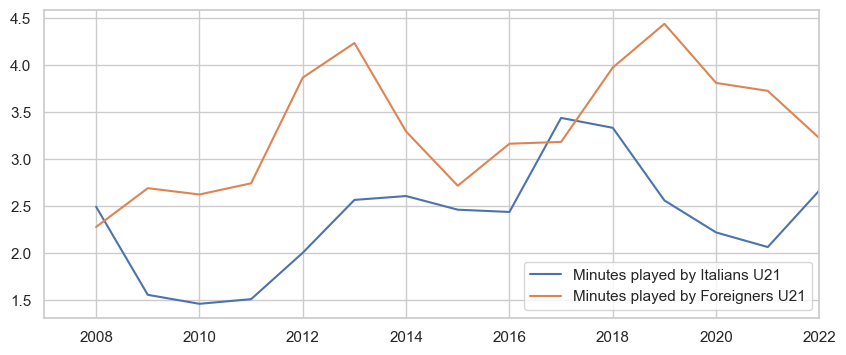

In [45]:
#fai la media di ogni tre anni per i minuti giocati da giocatori italiani e per i giocatori stranieri, poi creaci due lineplot

plt.rcParams['figure.figsize'] = [10, 4]
(mins_played["Minuti giocati Italiani"][40:]+mins_played["Minuti giocati Oriundi"][40:]).rolling(2).mean().plot(label='Minutes played by Italians U21')

(mins_played["Minuti giocati Stranieri"][40:]).rolling(2).mean().plot(label='Minutes played by Foreigners U21')
#(mins_played["Minuti giocati under21"][40:]).rolling(2).mean().plot()
#plt.xticks(rotation=90)
#adjust the size of the graph


plt.legend()



In [26]:
#correlazione tra il la percentuale di minuti giocati dagli under 21 stranieri e italiani nel periodo 2011-2012 e 2021-2022
from scipy.stats import pearsonr,spearmanr

corr_pearson, p_value = pearsonr(mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:],mins_played["Minuti giocati under21"][40:])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:],mins_played["Minuti giocati under21"][40:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")



Correlazione di Pearson: 0.6464639703584583
P-value Pearson: 0.006809663357140005
Correlazione di Spearman: 0.6323529411764706
P-value Spearman: 0.008577584103099355


In [75]:
#crea un datframe chiamato perc_under_ita_stra
perc_under_ita_stra=mins_played[41:]
#perc_under_ita_stra.head()
perc_under_ita_stra["Minuti giocati Stranieri"]=perc_under_ita_stra["Minuti giocati Stranieri"]/perc_under_ita_stra["Minuti giocati under21"]*100
perc_under_ita_stra["Minuti giocati Italiani"]=perc_under_ita_stra["Minuti giocati Italiani"]/perc_under_ita_stra["Minuti giocati under21"]*100+perc_under_ita_stra["Minuti giocati Oriundi"]/perc_under_ita_stra["Minuti giocati under21"]*100
#perc_under_ita_stra["Minuti giocati Oriundi"]=perc_under_ita_stra["Minuti giocati Oriundi"]/perc_under_ita_stra["Minuti giocati under21"]*100
perc_under_ita_stra=perc_under_ita_stra.drop(columns=["Minuti giocati Oriundi"])
#perc_under_ita_stra


In [14]:
#fai la media di ogni tre anni e crea un nuvo datframe
perc_under_ita_stra=perc_under_ita_stra.rolling(3).mean()

In [78]:
print(f"L'influenza percentuale di Minuti_under21_Stranieri sul trend è: {perc_under_ita_stra['Minuti giocati Stranieri'].mean()}")
print(f"La deviazione standard di Minuti_under21_Strasnieri sul trend è: {perc_under_ita_stra['Minuti giocati Stranieri'].std()}")
#intervallo di confidenza al 95%
confidence_interval_stra = stats.t.interval(0.95, len(perc_under_ita_stra["Minuti giocati Stranieri"])-1, loc=perc_under_ita_stra["Minuti giocati Stranieri"].mean(), scale=stats.sem(perc_under_ita_stra["Minuti giocati Stranieri"]))
print(f"Intervallo di Confidenza Minuti_under21_Strasnieri al 95%: {confidence_interval_stra}")

print(f"L'influenza percentuale di Minuti_under21_Italiani sul trend è: {perc_under_ita_stra['Minuti giocati Italiani'].mean()}")
print(f"deviazione standard di Minuti_under21_Italiani sul trend è: {perc_under_ita_stra['Minuti giocati Italiani'].std()}")
#intervallo di confidenza al 95%
confidence_interval_ita = stats.t.interval(0.95, len(perc_under_ita_stra["Minuti giocati Italiani"])-1, loc=perc_under_ita_stra["Minuti giocati Italiani"].mean(), scale=stats.sem(perc_under_ita_stra["Minuti giocati Italiani"]))
print(f"Intervallo di Confidenza Minuti_under21_Italiani al 95%: {confidence_interval_ita}")


L'influenza percentuale di Minuti_under21_Stranieri sul trend è: 59.09747043706466
La deviazione standard di Minuti_under21_Strasnieri sul trend è: 8.476518215584795
Intervallo di Confidenza Minuti_under21_Strasnieri al 95%: (54.403331112537344, 63.79160976159197)
L'influenza percentuale di Minuti_under21_Italiani sul trend è: 40.90252956293534
deviazione standard di Minuti_under21_Italiani sul trend è: 8.476518215584802
Intervallo di Confidenza Minuti_under21_Italiani al 95%: (36.20839023840803, 45.596668887462656)


In [76]:
perc_under_ita_stra.rolling(window=3).mean()[2:]

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri
2010-2011,4.212786,37.946809,62.053191
2011-2012,4.177255,33.821316,66.178684
2012-2013,5.295499,35.937759,64.062241
2013-2014,5.988703,35.262108,64.737892
2014-2015,6.394427,41.819332,58.180668
2015-2016,5.527246,44.624171,55.375829
2016-2017,5.594763,45.723871,54.276129
2017-2018,6.007886,49.413311,50.586689
2018-2019,7.014133,45.201586,54.798414
2019-2020,6.940103,45.030667,54.969333


## Bayesian changepoint detection con Ruptures

In [4]:
#modify the index of mins_played and get only the first part(examples: 2022-2023 becomes 2022, 2021-2022 becomes 2021)
mins_played.index=mins_played.index.str[:4].astype(int)
#convert the index of mins_played to DateTime
mins_played.index=pd.to_datetime(mins_played.index, format='%Y')

In [5]:
mins_played.index = mins_played.index.to_period('Y')

Punti di rottura trovati: [1977, 1984, 2012]
Punti di rottura trovati: [10, 17, 45]


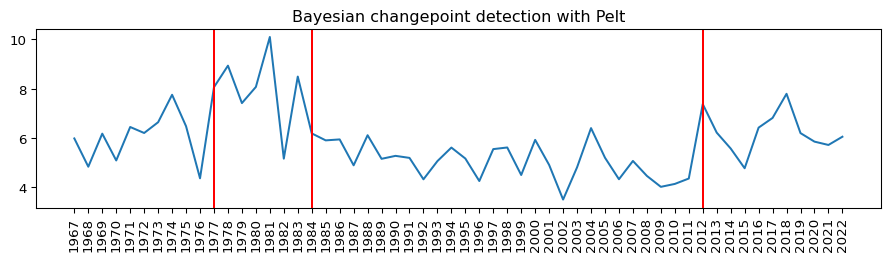

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(900/96, 250/96), dpi=96)
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions = mins_played["Minuti giocati under21"].values.reshape(-1, 1)

penalty=2*np.log(len(impressions))*np.std(impressions)**2
print
# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Pelt(model=model,jump=1).fit(impressions)
result = algo.predict(pen=7)

# Puoi visualizzare i punti di rottura sul grafico

#rpt.display(impressions,[], result)


# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result[0:-1]])

# Puoi visualizzare i punti di rottura sul grafico
#rpt.display(impressions,[], result)
ax.plot(impressions)
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r', )
ax.set_title("Bayesian changepoint detection with Pelt")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,56))
b=list(range(1967,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()

Punti di rottura trovati: [1977, 1985, 2011, 2023]
Punti di rottura trovati: [10, 18, 44]


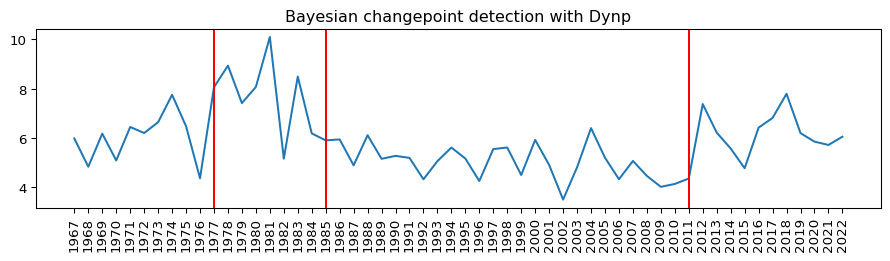

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(900/96, 250/96), dpi=96)

# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions = mins_played["Minuti giocati under21"].values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=3,jump=2).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
#rpt.display(impressions,[], result)
ax.plot(impressions)
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r', )
ax.set_title("Bayesian changepoint detection with Dynp")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,56))
b=list(range(1967,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()


Punti di rottura trovati: [1999, 2009, 2023]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

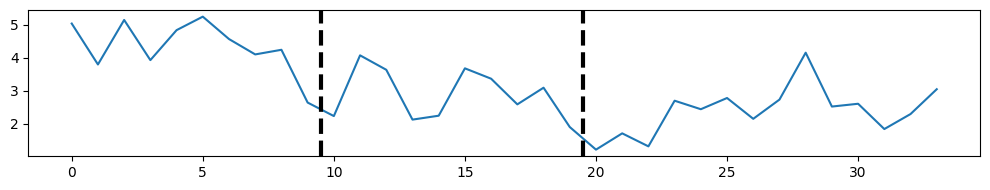

In [20]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_first_up_trend = (mins_played["Minuti giocati Italiani"][22:]+mins_played["Minuti giocati Oriundi"][22:]).values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=4,jump=5).fit(impressions_first_up_trend)
result = algo.predict(n_bkps=2)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1989 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_first_up_trend,[], result)

Punti di rottura trovati: [1973, 1985, 1989]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

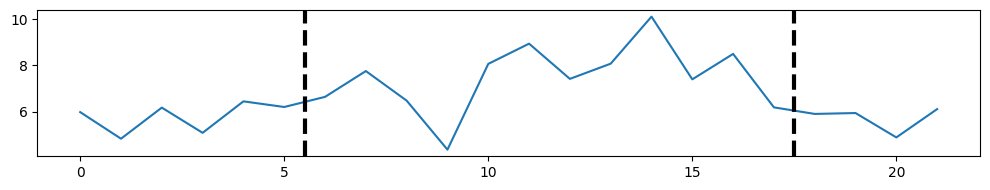

In [171]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_first_up_trend = mins_played["Minuti giocati under21"][0:22].values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=3).fit(impressions_first_up_trend)
result = algo.predict(n_bkps=2)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_first_up_trend,[], result)

Punti di rottura trovati: [2011, 2023]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

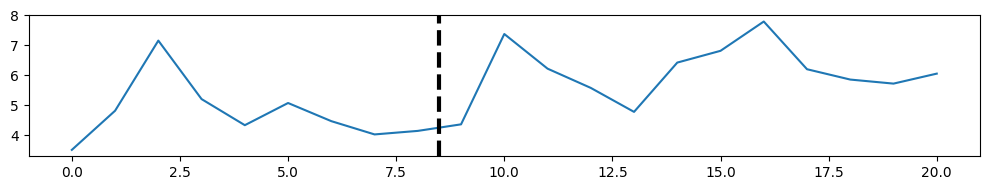

In [127]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_final_trend = mins_played["Minuti giocati under21"][50:].values.reshape(-1, 1)
# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=3).fit(impressions_final_trend)
result = algo.predict(n_bkps=1)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+2002 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_final_trend,[], result)

Punti di rottura trovati: [10, 17, 45, 56]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

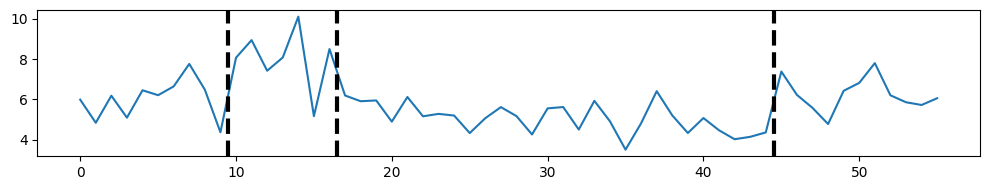

In [12]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l1"

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=1).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", result)

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions,[], result)

Punti di rottura trovati: [10, 17, 45]


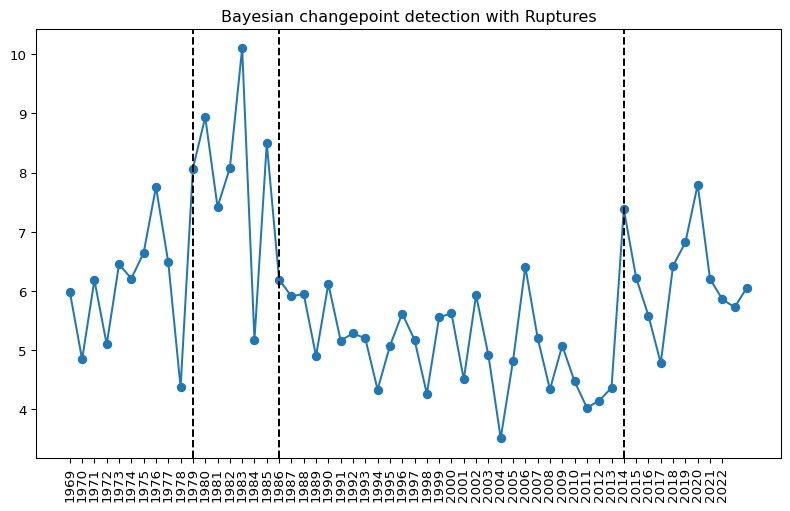

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(800/96, 500/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=3)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='k', linestyle='--')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,54))
b=list(range(1969,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()

Punti di rottura trovati: [22]


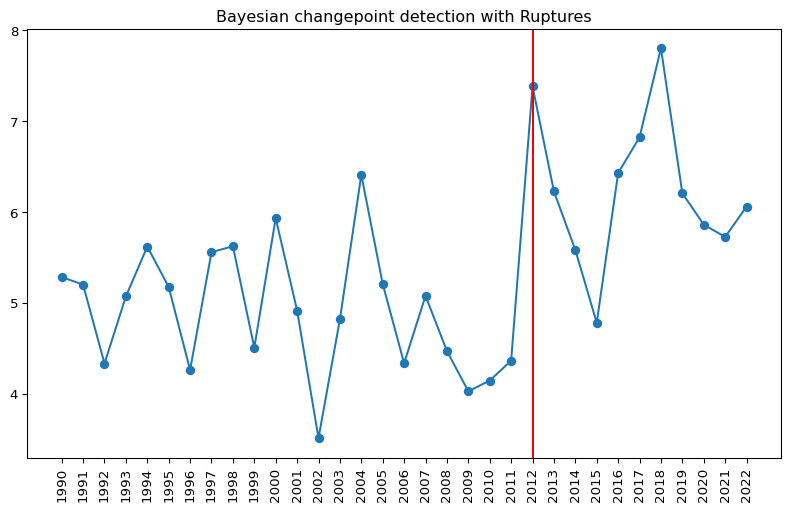

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(800/96, 500/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=1)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,33))
b=list(range(1990,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()



## Test Mann-Kendall

### Test Mann-Kendall under-21 2011/2012 to 2022/2023

In [69]:
mean_value = np.mean(mins_played["Minuti giocati under21"][45:])
print(f"Mean: {mean_value}")

# Calcola la varianza
variance_value = np.var(mins_played["Minuti giocati under21"][45:])
print(f"Variance: {variance_value}")

# Calcola l'intervallo di confidenza al 95%
confidence_interval = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][45:])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][45:]))
confidence_interval_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][45:])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][45:]))

print(f"Confidence Interval 95%: {confidence_interval}")
print(f"Intervallo di Confidenza al 90%: {confidence_interval_90}")

Mean: 6.258808177468464
Variance: 0.6464716130103549
Confidence Interval 95%: (5.692285914566664, 6.825330440370264)
Intervallo di Confidenza al 90%: (5.797975327751416, 6.719641027185512)


### Test Mann-Kendall under-21 1973/1974 to 1984/1985

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0041383639950869355, z=-2.8674177176068465, Tau=-0.6153846153846154, s=-48.0, var_s=268.6666666666667, slope=-0.21135620915032677, intercept=5.336467617349971)


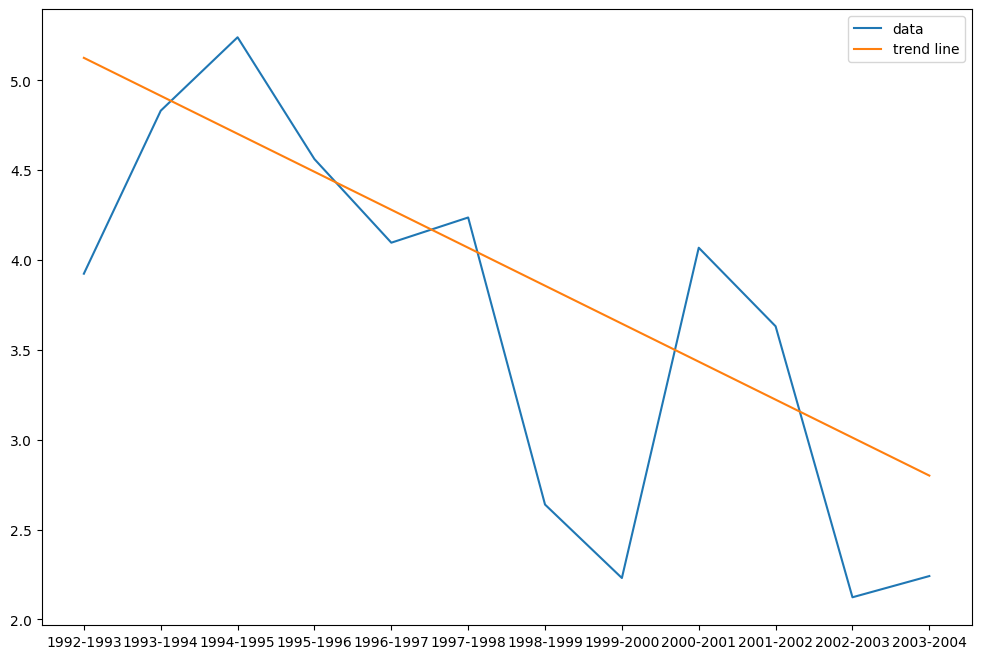

In [189]:
data = (mins_played["Minuti giocati Italiani"][24:37] + mins_played["Minuti giocati Oriundi"][24:37])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.original_test(data,alpha=0.075)

print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data[1:])
ax.plot(data[1:].index, trend_line[1:])
ax.legend(['data', 'trend line'])

### Test Mann-Kendall under-21 1985/1986 to 2011/2012

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.36033850469835116, z=-0.9147202616087684, Tau=-0.08571428571428572, s=-18.0, var_s=345.39913419913427, slope=-0.020047286591404277, intercept=5.1143171915230745)


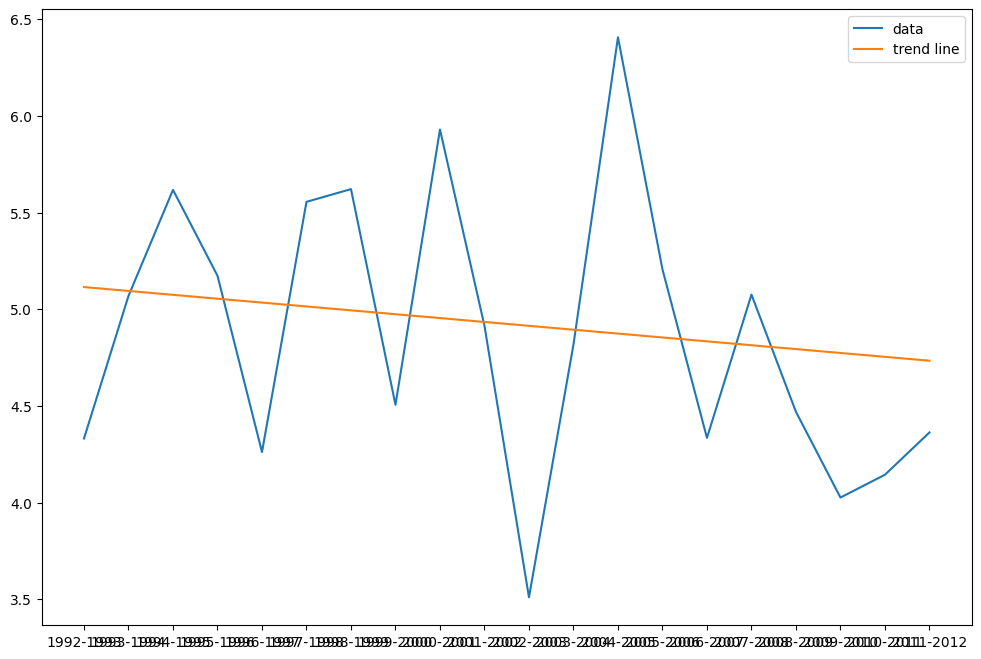

In [8]:
data = (mins_played["Minuti giocati under21"][25:46])
data_bis = (mins_played["Minuti giocati under21"][22:45])


fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data[:-1])
ax.plot(data[:-1].index, trend_line[:-1])
ax.legend(['data', 'trend line'])

### Test Mann-kendall e stazioniarietà ADCF 1992/1993 to 2011/2012

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0006624132333039601, z=3.4046812552279486, Tau=0.38235294117647056, s=52.0, var_s=224.38169934640516, slope=0.13155901116427432, intercept=4.670813397129187)


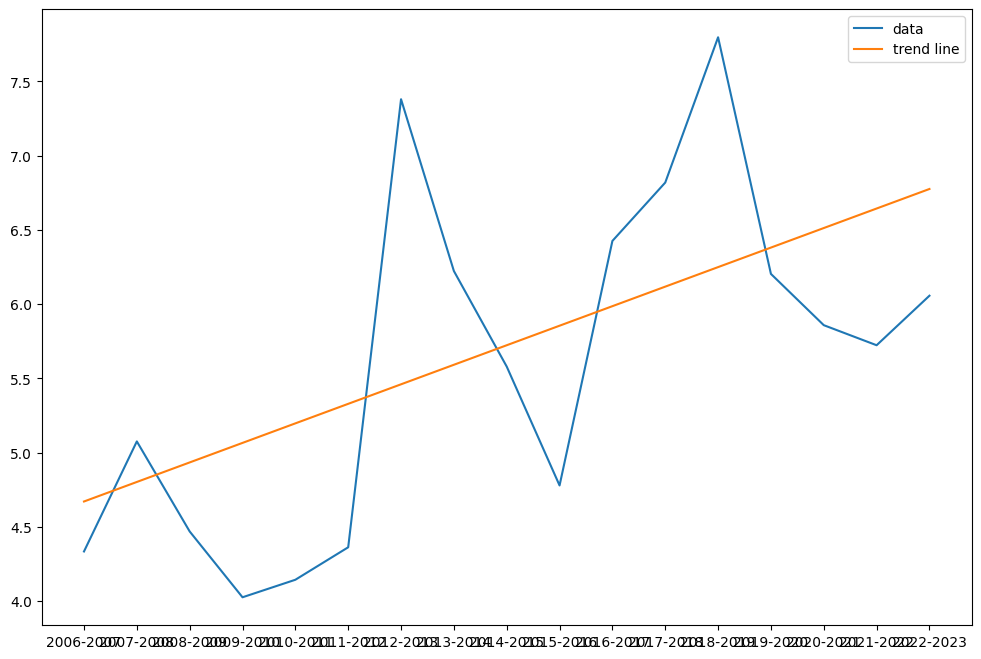

In [44]:
data = (mins_played["Minuti giocati under21"][39:60])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     Minuti giocati under21   No. Observations:                   23
Model:                     ARIMA(1, 0, 0)   Log Likelihood                 -23.267
Date:                    Thu, 14 Dec 2023   AIC                             52.534
Time:                            23:54:56   BIC                             55.941
Sample:                                 0   HQIC                            53.391
                                     - 23                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9103      0.158     31.041      0.000       4.600       5.220
ar.L1          0.0956      0.365      0.262      0.793      -0.619       0.810
sigma2         0.442

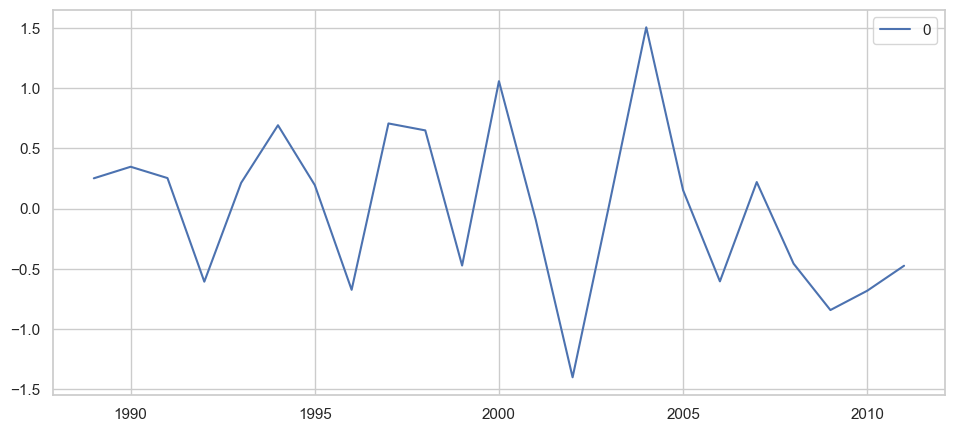

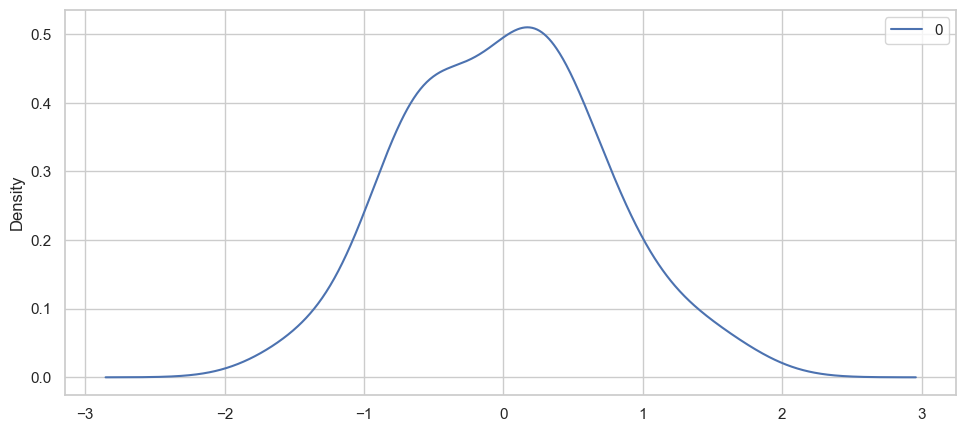

               0
count  23.000000
mean   -0.001046
std     0.680269
min    -1.400818
25%    -0.539431
50%     0.152756
75%     0.300312
max     1.505066


In [95]:
#fai il modello ARIMA

from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model

model = ARIMA(mins_played["Minuti giocati under21"][22:45], order=(2,3,5))
#add costant to the model

model_fit = model.fit()
# make prediction
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())



C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

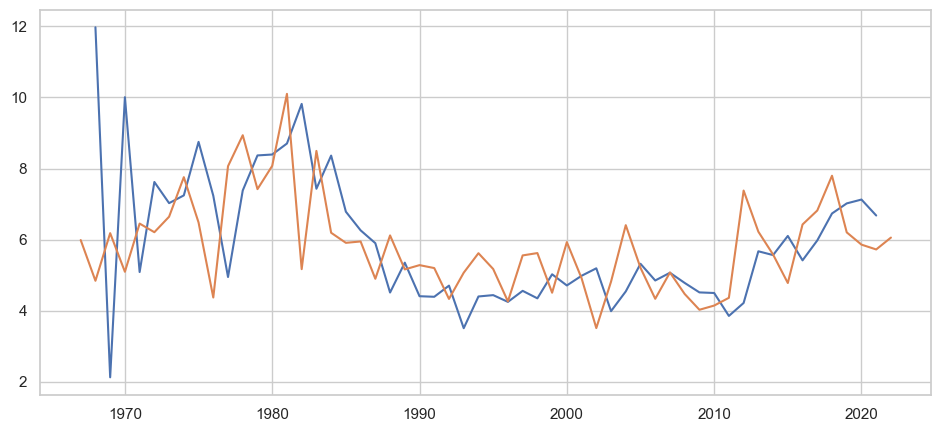

In [101]:
#plot the forecast of the model
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
model = ARIMA(mins_played["Minuti giocati under21"], order=(2,3,5))
model_fit = model.fit()
# forecast
yhat = model_fit.predict(1, 54)
plt.plot(yhat)
plt.plot(mins_played["Minuti giocati under21"])
plt.show()


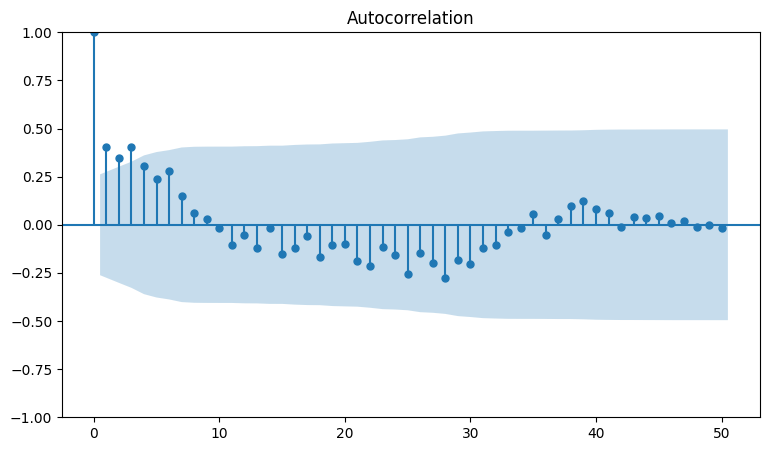

In [262]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mins_played["Minuti giocati under21"], lags=50)
plt.show()

In [104]:
#usa il modello AR AutoRegression
from statsmodels.tsa.ar_model import AutoReg
from random import random
# fit model
model = AutoReg(mins_played["Minuti giocati under21"][20:43], lags=3)
model_fit = model.fit()
print(model_fit.summary())

                              AutoReg Model Results                               
Dep. Variable:     Minuti giocati under21   No. Observations:                   23
Model:                         AutoReg(3)   Log Likelihood                 -16.909
Method:                   Conditional MLE   S.D. of innovations              0.564
Date:                    Thu, 14 Dec 2023   AIC                             43.818
Time:                            23:59:37   BIC                             48.797
Sample:                                 3   HQIC                            44.790
                                       23                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         5.8347      2.435      2.396      0.017       1.062      10.607
Minuti giocati under21.L1     0.0784      0.236      0

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [197]:
#fai la regressioe OLS condiderando anche i residui
# Fit a linear regression model (you can replace this with your specific model)
model = sm.OLS((mins_played['Minuti giocati Italiani'][39:]+mins_played['Minuti giocati Oriundi'][39:]), np.arange(len(mins_played['Minuti giocati Italiani'][39:]))).fit()
model21= sm.OLS(mins_played['Minuti giocati under21'][39:], np.arange(len(mins_played['Minuti giocati under21'][39:]))).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.740
Model:                            OLS   Adj. R-squared (uncentered):              0.724
Method:                 Least Squares   F-statistic:                              45.63
Date:                Thu, 07 Dec 2023   Prob (F-statistic):                    4.62e-06
Time:                        17:57:37   Log-Likelihood:                         -28.306
No. Observations:                  17   AIC:                                      58.61
Df Residuals:                      16   BIC:                                      59.45
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
